<a href="https://colab.research.google.com/github/MohitPunasiya/EE_769-Introduction-to-ML/blob/main/A3_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

B. Modify the code to run on co-lab without any new features. [1]

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip 
#https://stackoverflow.com/questions/49576657/is-there-anyway-i-can-download-the-file-in-google-colaboratory
#getting the zip file from the link shared in the code notebook

--2022-05-07 17:36:07--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.71, 18.160.200.126, 18.160.200.112, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  51.6MB/s    in 0.9s    

2022-05-07 17:36:08 (51.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
from zipfile import ZipFile
file_name = '/content/hymenoptera_data.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done') #https://stackoverflow.com/questions/56449262/how-to-upload-folders-to-google-colab

Done



Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data' #please provide the needed path while re-run
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


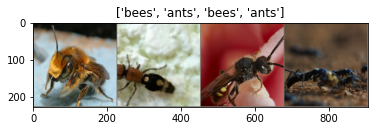

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
"We modified this function in such a way that aprt from returning trained model we also get training and validation accuracy and losses as well"

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        #print(f'Epoch {epoch}/{num_epochs - 1}')
        #print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

           # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
           
            if phase == 'train':
              train_loss.append(epoch_loss)   #modification in code to return training and validation losses and accuracy
              train_acc.append(epoch_acc)
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

       # print()

    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss,val_loss,train_acc,val_acc #returning train validation losses and accuracy along with tranined model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 2m 30s
Best val Acc: 0.947712


C. Modify the code to plot validation loss and accuracy after every training epoch. [2]


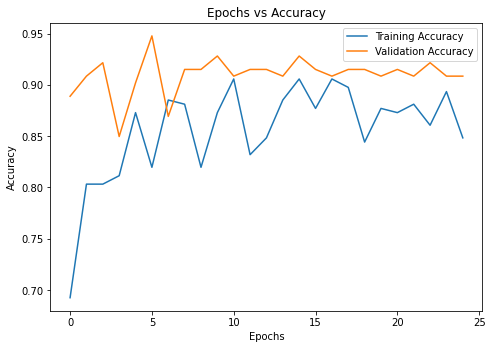

In [ ]:
num_epochs = 25
fig = plt.figure()  #creating figure object adding axes and plotting on those axes
axes = fig.add_axes([0, 0, 1, 1]) 
train_acc = [float(i.detach().cpu().numpy()) for i in model_ft[3]]  #the returned value was a list of tensor object this line converts this is converting them to a list of floats
val_acc = [float(i.detach().cpu().numpy()) for i in model_ft[4]]     #So that they can be plotted
axes.plot(np.arange(num_epochs), train_acc) #plotting training and validation accuracy
axes.plot(np.arange(num_epochs),val_acc)
axes.set_xlabel('Epochs') # Setting labels
axes.set_ylabel('Accuracy')
axes.set_title('Epochs vs Accuracy') #title setting
plt.legend(["Training Accuracy", "Validation Accuracy"]) 

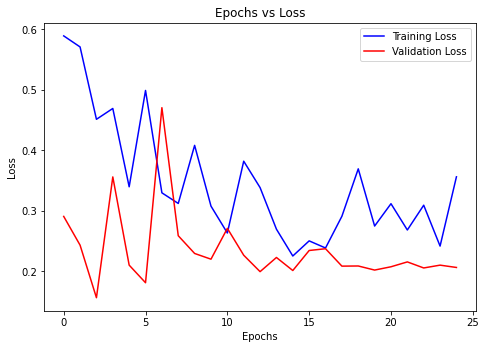

In [ ]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1]) 
axes.plot(np.arange(num_epochs), model_ft[1], 'b')
axes.plot(np.arange(num_epochs),model_ft[2],'r')
axes.set_xlabel('Epochs') # Notice the use of set_ to begin methods
axes.set_ylabel('Loss')
axes.set_title('Epochs vs Loss')
plt.legend(["Training Loss", "Validation Loss"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


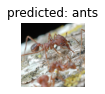

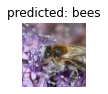

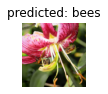

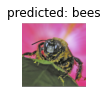

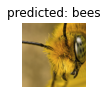

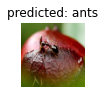

In [ ]:
visualize_model(model_ft[0])

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

D. Change the learning rate, momentum, and number of epochs at least three times to 
see the net effect on final validation loss and accuracy and its speed of convergence [1]

In [ ]:
  ##Defining a function which will return validation accuracy while taking arguements as Learning rate,Momentum & number of Epochs
def Model_conv(lr,momentum,epoch,weight_decay = 0):
    model_conv = torchvision.models.resnet18(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.

    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    model_conv = train_model(model_conv, criterion, optimizer_conv,
                            exp_lr_scheduler, num_epochs=epoch)
    return model_conv[4] 

In [ ]:
##Defining a function which would plot validation accuracy vs number of epochs with varying momentums
def plotter(momentums,learning_rate,Epochs,weight_decay=0):
  plt.figure(figsize=(20, 10))
  for momentum in momentums:
    print(f'With learning rate {learning_rate} & momentum {momentum}')
    ft = Model_conv(learning_rate,momentum,Epochs,weight_decay)
    print()
    new_lst = [float(i.detach().cpu().numpy()) for i in ft]  #the returned values were in pytorch tensor formate converting them in a list of integers
    plt.plot(range(1,len(new_lst)+1),new_lst)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title('Epoch vs Accuracy with various mometum')
  plt.legend(list(momentums))
  plt.figure(figsize=(10,6))
  plt.show()

With learning rate 0.01 & momentum 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 0m 34s
Best val Acc: 0.947712

With learning rate 0.01 & momentum 0.7
Training complete in 0m 33s
Best val Acc: 0.960784

With learning rate 0.01 & momentum 0.9
Training complete in 0m 33s
Best val Acc: 0.954248

With learning rate 0.01 & momentum 1
Training complete in 0m 33s
Best val Acc: 0.934641



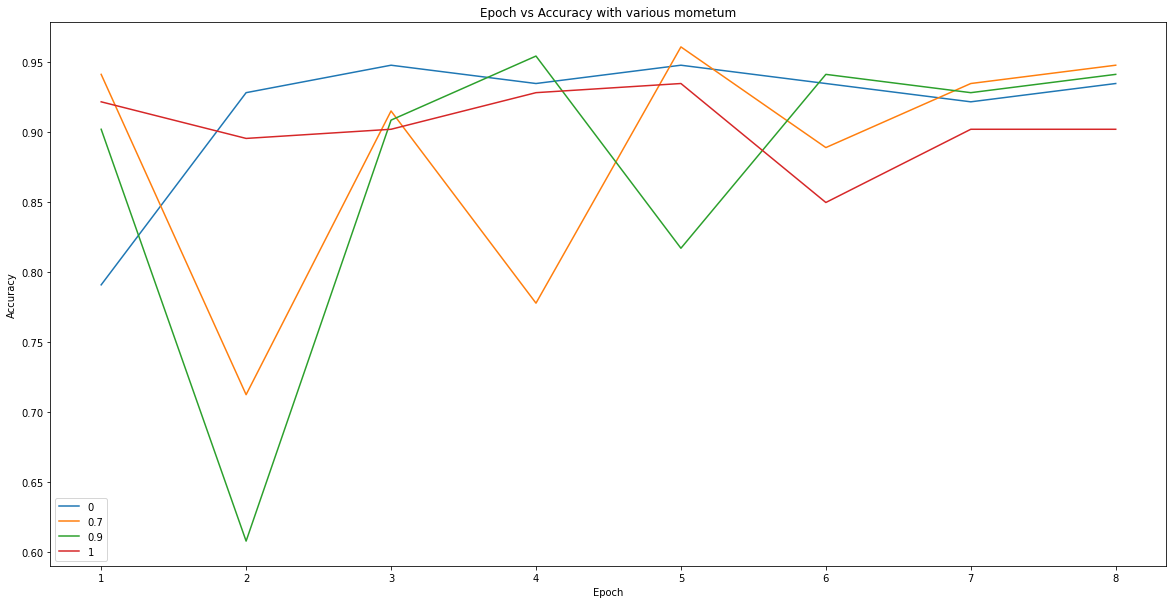

<Figure size 720x432 with 0 Axes>

With learning rate 0.001 & momentum 0
Training complete in 0m 33s
Best val Acc: 0.954248

With learning rate 0.001 & momentum 0.7
Training complete in 0m 33s
Best val Acc: 0.954248

With learning rate 0.001 & momentum 0.9
Training complete in 0m 33s
Best val Acc: 0.960784

With learning rate 0.001 & momentum 1
Training complete in 0m 34s
Best val Acc: 0.954248



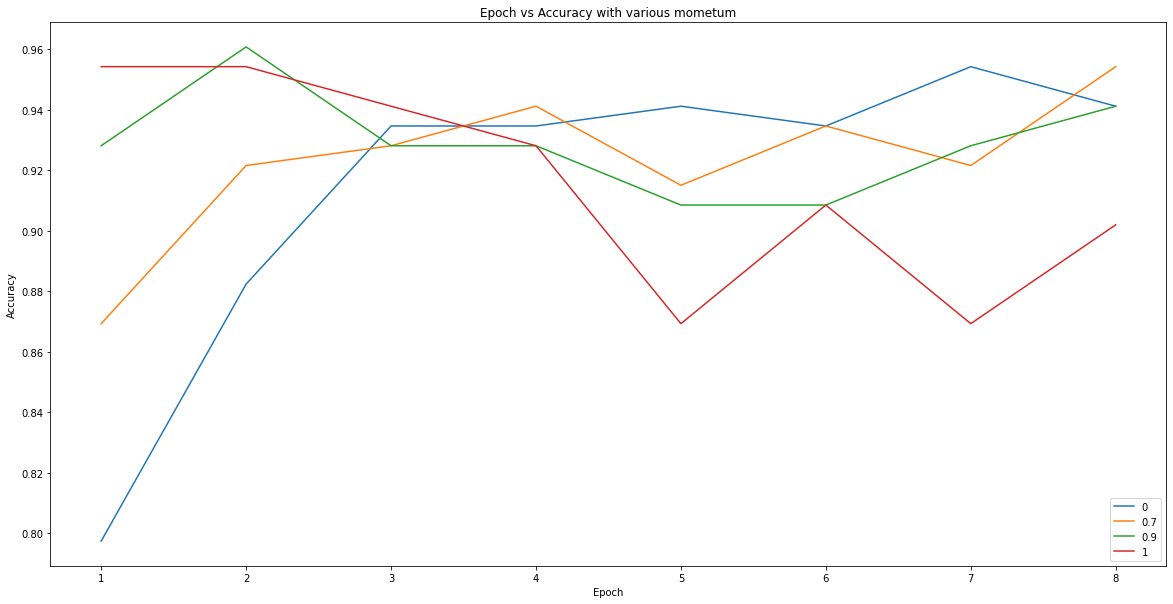

<Figure size 720x432 with 0 Axes>

With learning rate 0.0001 & momentum 0
Training complete in 0m 34s
Best val Acc: 0.758170

With learning rate 0.0001 & momentum 0.7
Training complete in 0m 34s
Best val Acc: 0.875817

With learning rate 0.0001 & momentum 0.9
Training complete in 0m 34s
Best val Acc: 0.934641

With learning rate 0.0001 & momentum 1
Training complete in 0m 33s
Best val Acc: 0.967320



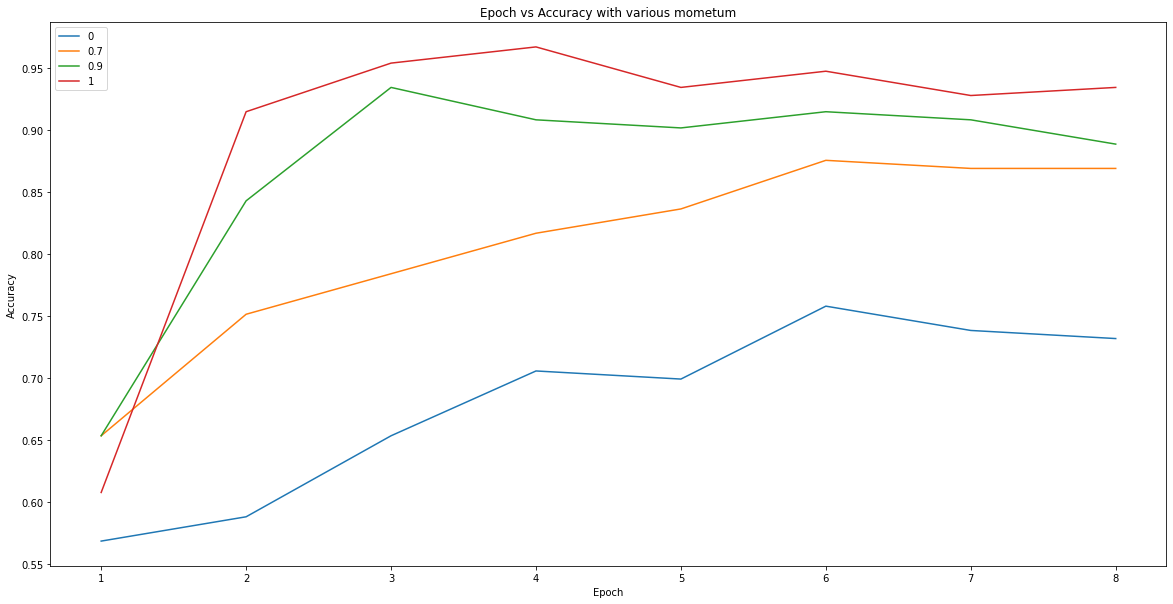

<Figure size 720x432 with 0 Axes>

In [ ]:
for learning_rate in [0.01,0.001,0.0001]:
  plotter([0,0.7,0.9,1],learning_rate,8)

- With learning rate 0.001 & momentum 1,
Training complete in 0m 34s
  **val Acc: 0.967320** 
- with higher learning rate 0.001 too high momentum leads to volatility and in only 3 epochs 95% accuracy can be achieved
- It can be inferred from the above graph that with increasing momentum we can achieve higher accuracy in lesser number of epochs


- And at momentum value 1 we are optimising the training process
but increasing momentum more than 1 further decreases the accuracy, this shows instablity in model due to high momentum

- One more thing that can be observed is if learning rate is high say 0.01 than momentum can be misguiding and lead to fluctuations
while if we take lesser learning rate 0.0001 or so than increasing momentum steadily leads to higher accuracy with increasing number of epochs

- And we tried with higher number of epochs as well but things doesn't get any better with increasing epochs we can achieve higher accuracies in less epochs with a proper momentum corresponding to each learning rate



With learning rate 1 & momentum 0.001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 2m 46s
Best val Acc: 0.947712



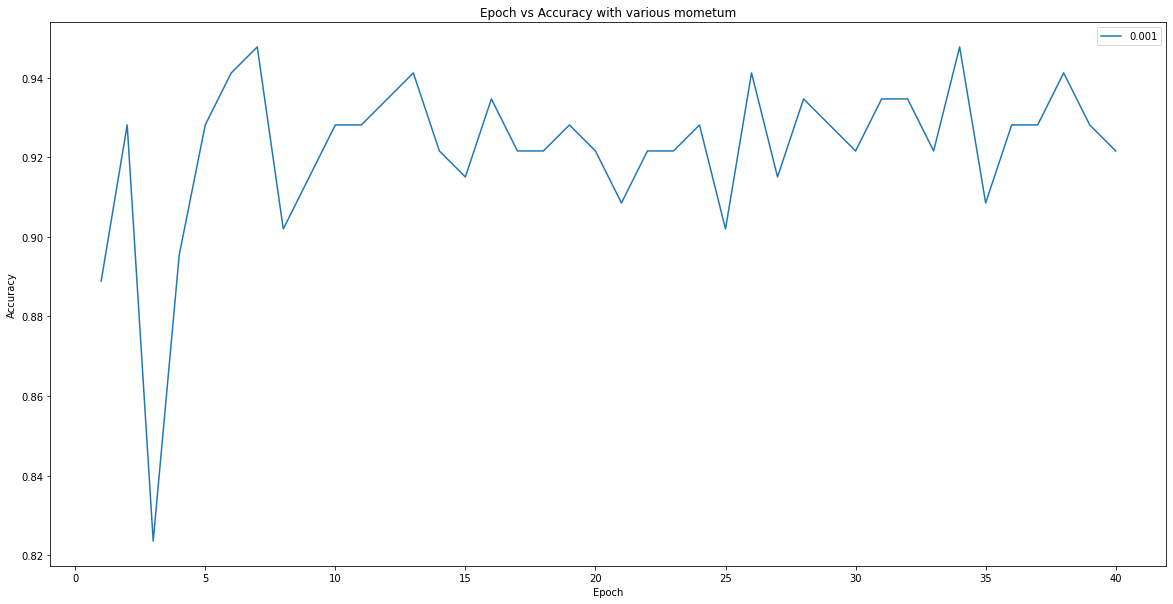

<Figure size 720x432 with 0 Axes>

In [ ]:
#lets see if increasing number of epochs does any improvement in accuracy or not 
plotter([0.001],1,40)
#From below plot its evident that beyond a certain number of epoch accuracy doesn't improve with increasing number of epoch

E. Introduce weight decay (L2 penalty on weights) and find a good value for the weight 
decay factor. [1]


Weight Decay 0
With learning rate 1 & momentum 0.001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 1m 3s
Best val Acc: 0.954248



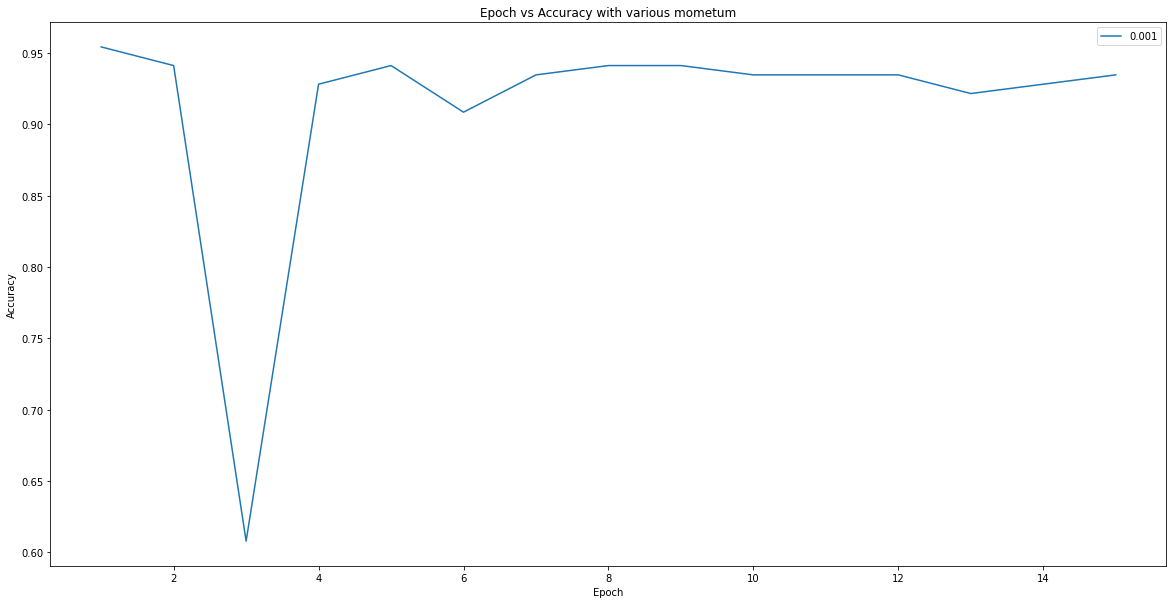

<Figure size 720x432 with 0 Axes>

Weight Decay 0.0001
With learning rate 1 & momentum 0.001
Training complete in 1m 4s
Best val Acc: 0.947712



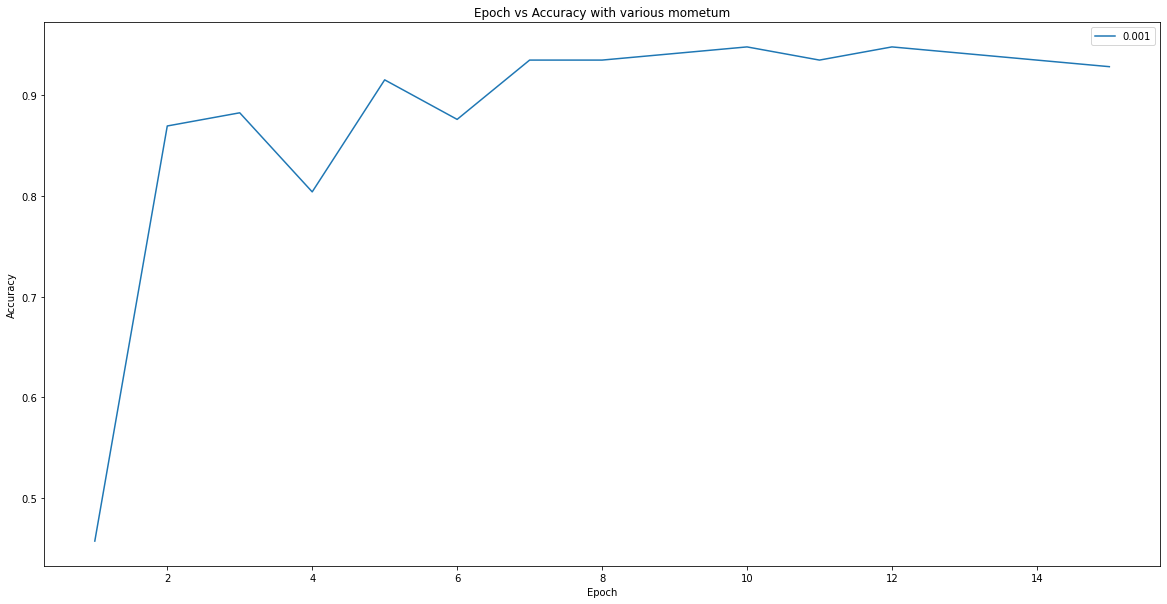

<Figure size 720x432 with 0 Axes>

Weight Decay 0.001
With learning rate 1 & momentum 0.001
Training complete in 1m 3s
Best val Acc: 0.960784



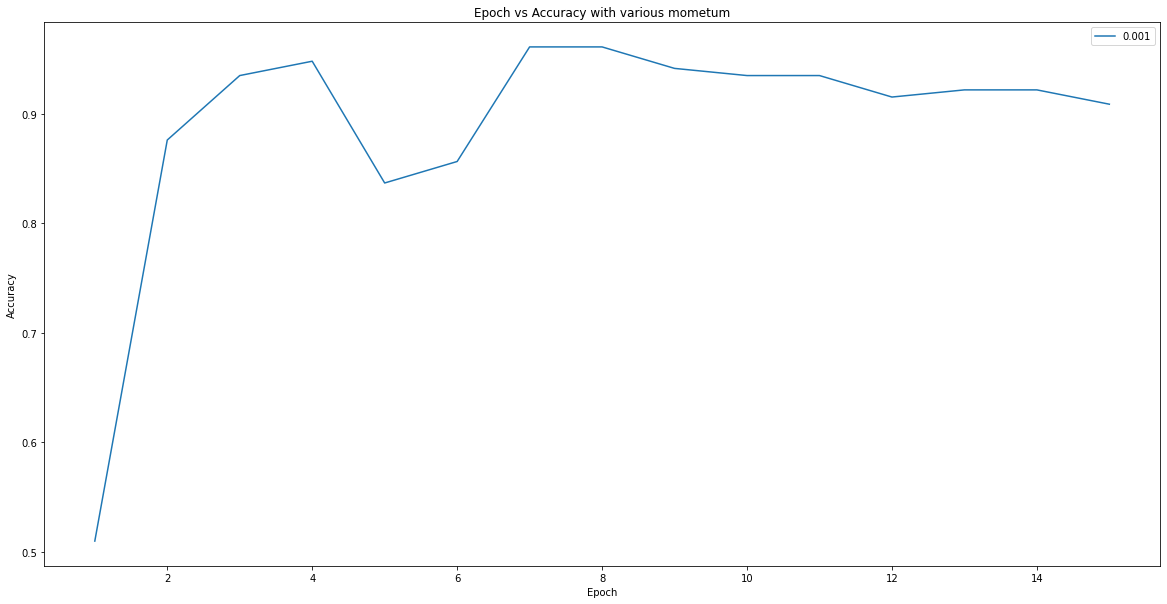

<Figure size 720x432 with 0 Axes>

Weight Decay 0.1
With learning rate 1 & momentum 0.001
Training complete in 1m 4s
Best val Acc: 0.947712



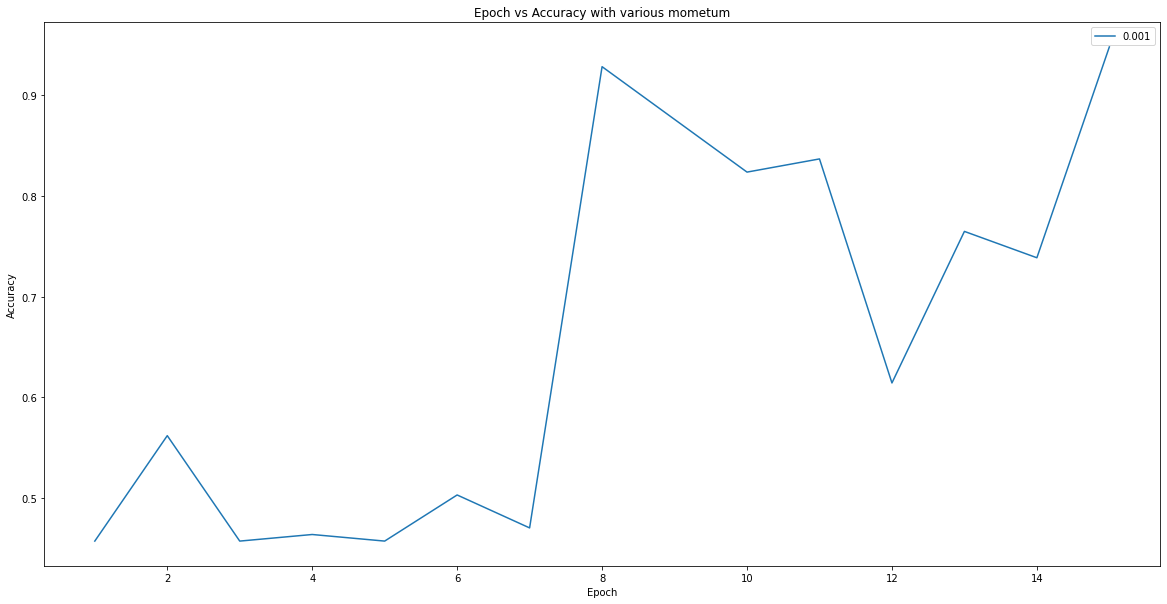

<Figure size 720x432 with 0 Axes>

In [ ]:
##To see how weight decay impact the performance we will try different weight decay for our best model parameters so far
## which are learning rate = 0.001 and momentum = 1
weight_decay = [0,0.0001,0.001,0.1]
for weight_decay in weight_decay:
  print(f'Weight Decay {weight_decay}')
  plotter([0.001],1,15,weight_decay)


**Inferences**

So, looking at performance over range of weight decay we can observe the following:

- At Weight Decay 0.001
- With learning rate 1 & momentum 0.001
- Best val Acc: 0.954248

-So best value of weight decay is 0.001
-Also this can be seen that increasing weight decay increases fluctuation in accuracy with each epoch


********************************************************************************


Train and evaluate


On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 1m 47s
Best val Acc: 0.954248


Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





Summary 
- We defined function to give validation accuracy as output
- We defined a function to plot validation accuracy with varying epochs while arguments needed were momentum,learning rate,epochs and weight decay
- we got a highest accuracy as  0.967320, With learning rate 0.001 & momentum 1
- than we checked if increasing number of epochs to very high values does a better job or not
- Introducing weight decay and finding its best value